In [5]:
!pip install eli5

  Using cached https://files.pythonhosted.org/packages/97/2f/c85c7d8f8548e460829971785347e14e45fa5c6617da374711dec8cb38cc/eli5-0.10.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/94/cd/7b37f2b658995033879719e1ea4c9f171bf7a14c16b79220bd19f9eda3fe/graphviz-0.13-py2.py3-none-any.whl
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [ ]:
#!pip install category_encoders

In [2]:
pwd

'/home/ec2-user/SageMaker/RC-v1.2-Predictive-Modelling/modelling_noteboooks'

In [139]:
import pandas as pd
import numpy as np
import random
import pickle
import gc
#import psycopg2
from matplotlib import pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, f1_score, r2_score, roc_auc_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)


import eli5
from eli5.sklearn import PermutationImportance
#import category_encoders as ce
#from catboost import CatBoostClassifier

In [147]:
path = '/home/ec2-user/SageMaker/RC-v1.2-Predictive-Modelling/pitcher_df_pickles/Greinke_df.pkl'

df = pd.read_pickle(path, compression='zip').reset_index()

In [148]:
#make binary fastball/not-fastball target feature:
df['fastball_target'] = (df['pitch_cat'] == 'fastball') * 1

#replace some categoricals with custom strategic ordinal encoding scale:

#description cols:
desc_map = {'called_strike':1,
            'swinging_strike':2,
            'foul_tip':3,
            'foul':4,
            'swinging_strike_blocked':5,
            'foul_bunt':6,
            'N/A':7,
            'hit_into_play':8,
            'ball':9,
            'blocked_ball':10,
            'hit_by_pitch':11,
            'hit_into_play_no_out':12,
            'hit_into_play_score':13}
desc_cols = ['L1_description', 'L2_description', 'L3_description']
df[desc_cols] = df[desc_cols].replace(desc_map)

#pitch_result cols
pitch_result_map = {'S':1, 'N/A':2, 'X':3, 'B':4}
result_cols = ['L1_pitch_result', 'L2_pitch_result']
df[result_cols] = df[result_cols].replace(pitch_result_map)

#pitch_type cols
pitch_type_map = {'FA':1, 'FF':1, 'FT':2, 'FC':2, 'FS':2, 'SI':2, 'SF':2, 'N/A':2.5, 'SL':3,
                  'CB':4, 'CU':4, 'SC':5, 'KC':5, 'CH':6, 'KN':7, 'EP':8, 'FO':9, 'PO':9}
pitch_type_cols = ['L1_pitch_type', 'L2_pitch_type', 'L3_pitch_type']
df[pitch_type_cols] = df[pitch_type_cols].replace(pitch_type_map)

#count_cat
count_cat_map = {'ahead':1,'neutral':2, 'behind':3}
df['count_cat'] = df['count_cat'].replace(count_cat_map)

#count
_count_map = {'02':1, '12':2, '01':3, '22':4, '11':5, '00':6, '21':7, '32':8, '10':9, '20':10, '31':11, '30':12}
df['_count'] = df['_count'].replace(_count_map)

#for swung and chased, make unknown (-1) set to 0, and 0 (didnt swing/chase) set to -1:
swung_and_chased_cols = ['L1_batter_swung', 'L1_chased', 'L2_chased', 'L3_chased']

def swung_chase_edit(x):
    if x == 0:
        return -1
    elif x == -1:
        return 0
    else:
        return x
    
for col in swung_and_chased_cols:
    df[col] = df[col].apply(swung_chase_edit)
    
#fill remaining misc categories to numerics:
misc_map = {'L':-1, 'R':2, 'Top':-1, 'Bot': 1, 'Standard':0, 'Infield shift': 0.5, 'Strategic':1, '4th outfielder':2}
df = df.replace(misc_map)

df['year'] = df['year'].cat.codes

In [149]:
df.head()

,index,pitch_type,game_date,pitcher,on_3b,on_2b,on_1b,outs_when_up,inning,catcher_id,sz_top,sz_bot,at_bat_number,pitch_number,bat_score,stand,inning_topbot,if_fielding_alignment,score_diff,bases_loaded,fastball_perc_faced,fastball_chase_perc,fastball_bip_swung_perc,fastball_taken_strike_perc,fastball_est_woba,fastball_babip,fastball_iso_value,breaking_perc_faced,breaking_chase_perc,breaking_bip_swung_perc,breaking_taken_strike_perc,breaking_est_woba,breaking_babip,breaking_iso_value,offspeed_perc_faced,offspeed_chase_perc,offspeed_bip_swung_perc,offspeed_taken_strike_perc,offspeed_est_woba,offspeed_babip,offspeed_iso_value,pitchout_perc_faced,balls,strikes,player_name,of_fielding_alignment,_count,count_cat,pitch_cat,overall_fastball_perc,count_cat_fastball_perc,overall_offspeed_perc,count_cat_offspeed_perc,overall_breaking_perc,count_cat_breaking_perc,pitch_count,L1_pitch_type,L1_pitch_result,L1_description,L1_pitch_zone,L1_batter_swung,L1_chased,L2_pitch_type,L2_pitch_result,L2_description,L2_pitch_zone,L2_chased,L3_pitch_type,L3_description,L3_pitch_zone,L3_chased,L5_fastball_perc,L15_fastball_perc,L5_breaking_perc,L15_breaking_perc,L5_offspeed_perc,L15_offspeed_perc,L5_strike_perc,L15_strike_perc,batting_order_slot,pitcher_AB,prev_ab_run_scored,prev_ab_homerun,prev_ab_walk,prev_ab_basehit,prev_ab_strikeout,PB_fastball,PB_breaking,PB_offspeed,month,year,on_base,fastball_target
0,8770,FF,2018-03-31,425844.0,0.0,0.0,0.0,0.0,1.0,425772.0,3.1773,1.2787,1.0,1.0,0.0,-1,-1,0.5,0.0,0,65.776695,29.307116,39.467312,38.118214,0.40704,0.246085,0.221477,24.895977,36.879433,35.422344,28.474577,0.471,0.221649,0.293814,9.327323,37.572254,40.277779,17.708334,0.459517,0.28,0.226667,0.0,0,0,Zack Greinke,0,6,2,fastball,45.623501,49.248748,28.177458,24.207012,26.199041,26.544240,1.0,2.5,2,7,-1.0,0.0,0.0,2.5,2,7,-1.0,0.0,2.5,7,-1.0,0.0,48.126065,48.126065,28.892675,28.892675,22.981261,22.981261,46.405451,46.405451,1.0,0.0,0.0,0.0,0.0,0.0,0.0,62.500000,25.000000,12.500000,3,0,0,1
1,8771,FF,2018-03-31,425844.0,0.0,0.0,0.0,0.0,1.0,425772.0,3.2751,1.7060,1.0,2.0,0.0,-1,-1,0.5,0.0,0,65.776695,29.307116,39.467312,38.118214,0.40704,0.246085,0.221477,24.895977,36.879433,35.422344,28.474577,0.471,0.221649,0.293814,9.327323,37.572254,40.277779,17.708334,0.459517,0.28,0.226667,0.0,0,1,Zack Greinke,0,3,1,fastball,45.623501,43.985419,28.177458,25.030377,26.199041,30.984204,2.0,1,1,1,1.0,-1.0,-1.0,2.5,2,7,-1.0,0.0,2.5,7,-1.0,0.0,48.126065,48.126065,28.892675,28.892675,22.981261,22.981261,46.405451,46.405451,1.0,0.0,0.0,0.0,0.0,0.0,0.0,47.826087,39.130435,13.043478,3,0,0,1
2,8772,FF,2018-03-31,425844.0,0.0,0.0,0.0,0.0,1.0,425772.0,3.3420,1.4434,1.0,3.0,0.0,-1,-1,0.5,0.0,0,65.776695,29.307116,39.467312,38.118214,0.40704,0.246085,0.221477,24.895977,36.879433,35.422344,28.474577,0.471,0.221649,0.293814,9.327323,37.572254,40.277779,17.708334,0.459517,0.28,0.226667,0.0,1,1,Zack Greinke,0,5,1,fastball,45.623501,43.985419,28.177458,25.030377,26.199041,30.984204,3.0,1,4,9,12.0,-1.0,-1.0,1,1,1,1.0,-1.0,2.5,7,-1.0,0.0,48.126065,48.126065,28.892675,28.892675,22.981261,22.981261,46.405451,46.405451,1.0,0.0,0.0,0.0,0.0,0.0,0.0,47.826087,39.130435,13.043478,3,0,0,1
3,8773,FF,2018-03-31,425844.0,0.0,0.0,0.0,0.0,1.0,425772.0,3.1773,1.2787,1.0,4.0,0.0,-1,-1,0.5,0.0,0,65.776695,29.307116,39.467312,38.118214,0.40704,0.246085,0.221477,24.895977,36.879433,35.422344,28.474577,0.471,0.221649,0.293814,9.327323,37.572254,40.277779,17.708334,0.459517,0.28,0.226667,0.0,1,2,Zack Greinke,0,2,1,fastball,45.623501,43.985419,28.177458,25.030377,26.199041,30.984204,4.0,1,1,1,7.0,-1.0,-1.0,1,4,9,12.0,-1.0,1,1,1.0,-1.0,48.126065,48.126065,28.892675,28.892675,22.981261,22.981261,46.405451,46.405451,1.0,0.0,0.0,0.0,0.0,0.0,0.0,47.826087,39.130435,13.043478,3,0,0,1
4,8774,SL,2018-03-31,425844.0,0.0,0.0,0.0,0.0,1.0,425772.0,3.3319,1.5432,1.0,5.0,0.0,-1,-1,0.5,0.0,0,65.776695,29.307116,39.467312,38.118214,0.40704,0.246085,0.221477,24.895977,36.879433,35.422344,28.474577,0.471,0.221649,0.293814,9.3273

In [150]:
df.fastball_target.value_counts(normalize=True)

0    0.518739
1    0.481261
Name: fastball_target, dtype: float64

In [12]:
# # #label encode some cat variables
# from sklearn.preprocessing import LabelEncoder

# cat_cols = ['stand', 'inning_topbot', 'if_fielding_alignment', 'of_fielding_alignment', 'count_cat',
#            'L1_pitch_type', 'L1_pitch_result', 'L1_description', 'L1_pitch_zone', 'L1_batter_swung', 'L1_chased',
#            'L2_pitch_type', 'L2_pitch_result','L2_description','L2_pitch_zone','L2_chased','L3_pitch_type',
#            'L3_description','L3_pitch_zone','L3_chased', 'catcher_id', '_count', 'pitch_cat', 'batting_order_slot',
#            'year']

# le = LabelEncoder()

# le_df = df.copy()

# for col in cat_cols:
#     try:
#         le_df[col] = le.fit_transform(le_df[col])
#     except:
#         print(col)

# le_df.head()

,index,pitch_type,game_date,pitcher,on_3b,on_2b,on_1b,outs_when_up,inning,catcher_id,sz_top,sz_bot,at_bat_number,pitch_number,bat_score,stand,inning_topbot,if_fielding_alignment,score_diff,bases_loaded,fastball_perc_faced,fastball_chase_perc,fastball_bip_swung_perc,fastball_taken_strike_perc,fastball_est_woba,fastball_babip,fastball_iso_value,breaking_perc_faced,breaking_chase_perc,breaking_bip_swung_perc,breaking_taken_strike_perc,breaking_est_woba,breaking_babip,breaking_iso_value,offspeed_perc_faced,offspeed_chase_perc,offspeed_bip_swung_perc,offspeed_taken_strike_perc,offspeed_est_woba,offspeed_babip,offspeed_iso_value,pitchout_perc_faced,balls,strikes,player_name,of_fielding_alignment,_count,count_cat,pitch_cat,overall_fastball_perc,count_cat_fastball_perc,overall_offspeed_perc,count_cat_offspeed_perc,overall_breaking_perc,count_cat_breaking_perc,pitch_count,L1_pitch_type,L1_pitch_result,L1_description,L1_pitch_zone,L1_batter_swung,L1_chased,L2_pitch_type,L2_pitch_result,L2_description,L2_pitch_zone,L2_chased,L3_pitch_type,L3_description,L3_pitch_zone,L3_chased,L5_fastball_perc,L15_fastball_perc,L5_breaking_perc,L15_breaking_perc,L5_offspeed_perc,L15_offspeed_perc,L5_strike_perc,L15_strike_perc,batting_order_slot,pitcher_AB,prev_ab_run_scored,prev_ab_homerun,prev_ab_walk,prev_ab_basehit,prev_ab_strikeout,PB_fastball,PB_breaking,PB_offspeed,month,year,on_base,fastball_target
0,8770,FF,2018-03-31,425844.0,0.0,0.0,0.0,0.0,1.0,0,3.1773,1.2787,1.0,1.0,0.0,0,1,0,0.0,0,65.776695,29.307116,39.467312,38.118214,0.40704,0.246085,0.221477,24.895977,36.879433,35.422344,28.474577,0.471,0.221649,0.293814,9.327323,37.572254,40.277779,17.708334,0.459517,0.28,0.226667,0.0,0,0,Zack Greinke,1,0,2,1,45.623501,49.248748,28.177458,24.207012,26.199041,26.544240,1.0,7,1,0,0,0,0,7,1,0,0,0,7,0,0,0,48.126065,48.126065,28.892675,28.892675,22.981261,22.981261,46.405451,46.405451,1,0.0,0.0,0.0,0.0,0.0,0.0,62.500000,25.000000,12.500000,3,0,0,1
1,8771,FF,2018-03-31,425844.0,0.0,0.0,0.0,0.0,1.0,0,3.2751,1.7060,1.0,2.0,0.0,0,1,0,0.0,0,65.776695,29.307116,39.467312,38.118214,0.40704,0.246085,0.221477,24.895977,36.879433,35.422344,28.474577,0.471,0.221649,0.293814,9.327323,37.572254,40.277779,17.708334,0.459517,0.28,0.226667,0.0,0,1,Zack Greinke,1,1,0,1,45.623501,43.985419,28.177458,25.030377,26.199041,30.984204,2.0,4,2,3,1,1,1,7,1,0,0,0,7,0,0,0,48.126065,48.126065,28.892675,28.892675,22.981261,22.981261,46.405451,46.405451,1,0.0,0.0,0.0,0.0,0.0,0.0,47.826087,39.130435,13.043478,3,0,0,1
2,8772,FF,2018-03-31,425844.0,0.0,0.0,0.0,0.0,1.0,0,3.3420,1.4434,1.0,3.0,0.0,0,1,0,0.0,0,65.776695,29.307116,39.467312,38.118214,0.40704,0.246085,0.221477,24.895977,36.879433,35.422344,28.474577,0.471,0.221649,0.293814,9.327323,37.572254,40.277779,17.708334,0.459517,0.28,0.226667,0.0,1,1,Zack Greinke,1,4,0,1,45.623501,43.985419,28.177458,25.030377,26.199041,30.984204,3.0,4,0,1,11,1,1,4,2,3,1,1,7,0,0,0,48.126065,48.126065,28.892675,28.892675,22.981261,22.981261,46.405451,46.405451,1,0.0,0.0,0.0,0.0,0.0,0.0,47.826087,39.130435,13.043478,3,0,0,1
3,8773,FF,2018-03-31,425844.0,0.0,0.0,0.0,0.0,1.0,0,3.1773,1.2787,1.0,4.0,0.0,0,1,0,0.0,0,65.776695,29.307116,39.467312,38.118214,0.40704,0.246085,0.221477,24.895977,36.879433,35.422344,28.474577,0.471,0.221649,0.293814,9.327323,37.572254,40.277779,17.708334,0.459517,0.28,0.226667,0.0,1,2,Zack Greinke,1,5,0,1,45.623501,43.985419,28.177458,25.030377,26.199041,30.984204,4.0,4,2,3,7,1,1,4,0,1,11,1,4,3,1,1,48.126065,48.126065,28.892675,28.892675,22.981261,22.981261,46.405451,46.405451,1,0.0,0.0,0.0,0.0,0.0,0.0,47.826087,39.130435,13.043478,3,0,0,1
4,8774,SL,2018-03-31,425844.0,0.0,0.0,0.0,0.0,1.0,0,3.3319,1.5432,1.0,5.0,0.0,0,1,0,0.0,0,65.776695,29.307116,39.467312,38.118214,0.40704,0.246085,0.221477,24.895977,36.879433,35.422344,28.474577,0.471,0.221649,0.293814,9.327323,37.572254,40.277779,17.708334,0.459517,0.28,0.226667,0.0,1,2,Zack Greinke,1,5,0,0,45.623501,43.985419,28.177458,25.030377,26.199041,30.984204,5.0,4,2,4,11,2,2,4,2,3,7,1,4,

## Split into Train/Test

In [151]:
#90% train / 10% held out test (will use validation set within train)

def train_test_split_by_date(df, train_fraction):
    train_idx = int(len(df) * train_fraction)
    train_end_date = df.loc[train_idx].game_date
    train = df[df['game_date'] < train_end_date]
    test = df[df['game_date'] >= train_end_date]
    print('train shape: ' + str(train.shape))
    print('test shape: '+ str(test.shape))
    return train, test

In [152]:
train, test = train_test_split_by_date(le_df, .85)

train shape: (4910, 93)
test shape: (960, 93)


In [153]:
#target = 'pitch_cat'
target = 'fastball_target'

drop_cols = ['index', 'player_name', 'game_date', 'pitch_cat', 'pitcher', 'pitch_type', target]

X = train.drop(columns=drop_cols)
X_test = test.drop(columns=drop_cols)

y = train[target]
y_test = test[target]

X.shape, X_test.shape, y.shape, y_test.shape

((4910, 86), (960, 86), (4910,), (960,))

## Scale the Float columns

In [154]:
scale_cols = ['fastball_perc_faced', 'fastball_chase_perc', 'fastball_bip_swung_perc', 'fastball_taken_strike_perc',
              'fastball_est_woba', 'fastball_babip', 'fastball_iso_value', 'breaking_perc_faced', 'breaking_chase_perc',
              'breaking_bip_swung_perc', 'breaking_taken_strike_perc', 'breaking_est_woba', 'breaking_babip',
              'breaking_iso_value', 'offspeed_perc_faced', 'offspeed_chase_perc', 'offspeed_bip_swung_perc',
              'offspeed_taken_strike_perc', 'offspeed_est_woba', 'offspeed_babip', 'offspeed_iso_value',
              'pitchout_perc_faced', 'overall_fastball_perc', 'count_cat_fastball_perc', 'overall_breaking_perc',
              'count_cat_breaking_perc', 'overall_offspeed_perc', 'count_cat_offspeed_perc', 'L5_fastball_perc',
              'L15_fastball_perc', 'L5_breaking_perc', 'L15_breaking_perc', 'L5_offspeed_perc', 'L15_offspeed_perc',
              'L5_strike_perc', 'L15_strike_perc', 'PB_fastball', 'PB_breaking', 'PB_offspeed']

scaler = RobustScaler()
X[scale_cols] = scaler.fit_transform(X[scale_cols].values)

X_test[scale_cols] = scaler.transform(X_test[scale_cols].values)

## Random Forest

In [155]:
%%time

#train/validation split
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.15, 
#                                                  random_state=42, stratify=y)

param_grid = {
    'n_estimators': [50],# 75, 100, 125, 150, 200],#  [50, 100,]
    'max_depth': [2, 4, 6],#, 8, 10, 15], #
    'min_samples_split': [5, 8],# 12, 18, 25],
    'min_samples_leaf': [3],# 5, 7],# 10],
    'max_features': ['auto', 0.5, 0.75],# 0.9],
    'class_weight': [None],#, 'balanced', 'balanced_subsample'],
    'warm_start': [False, True],
    'oob_score': [False, True]#, True],
}

rfc = RandomForestClassifier(n_jobs=-1, random_state=42, criterion='gini', bootstrap=True)

search = GridSearchCV(
    estimator = rfc, 
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    verbose=10,
    return_train_score=True)

search.fit(X, y)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:  

CPU times: user 8.95 s, sys: 2.35 s, total: 11.3 s
Wall time: 31.7 s


In [157]:
search_results = pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score')
search_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,param_oob_score,param_warm_start,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
39,0.677919,0.090890,0.331558,0.107403,None,4,0.5,3,8,50,True,True,"{'class_weight': None, 'max_depth': 4, 'max_fe...",0.598169,0.571283,0.598778,0.604888,0.579001,0.590428,0.012929,1,0.663356,0.663187,0.662678,0.657332,0.657419,0.660795,0.002801
36,0.681831,0.041495,0.195414,0.022806,None,4,0.5,3,8,50,False,False,"{'class_weight': None, 'max_depth': 4, 'max_fe...",0.598169,0.571283,0.598778,0.604888,0.579001,0.590428,0.012929,1,0.663356,0.663187,0.662678,0.657332,0.657419,0.660795,0.002801
37,0.556473,0.069018,0.168804,0.045095,None,4,0.5,3,8,50,False,True,"{'class_weight': None, 'max_depth': 4, 'max_fe...",0.598169,0.571283,0.598778,0.604888,0.579001,0.590428,0.012929,1,0.663356,0.663187,0.662678,0.657332,0.657419,0.660795,0.002801
38,0.649469,0.157905,0.242391,0.031192,None,4,0.5,3,8,50,True,False,"{'class_weight': None, 'max_depth': 4, 'max_fe...",0.598169,0.571283,0.598778,0.604888,0.579001,0.590428,0.012929,1,0.663356,0.663187,0.662678,0.657332,0.657419,0.660795,0.002801
67,1.727886,0.219630,0.325079,0.063698,None,6,0.75,3,5,50,True,True,"{'class_weight': None, 'max_depth': 6, 'max_fe...",0.593082,0.580448,0.594705,0.602851,0.575943,0.589409,0.009836,5,0.753247,0.739817,0.754837,0.735234,0.745737,0.745774,0.007544


In [54]:
search_results.iloc[0]['params']

{'class_weight': None,
 'max_depth': 4,
 'max_features': 0.5,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 50,
 'oob_score': True,
 'warm_start': True}

In [92]:
def get_top_n_models(search_results, n, accuracy_metric='accuracy'):
    results_list = []
    for i in range(50):
        model_dict = {}
        params = search_results.iloc[i]['params']
        model = RandomForestClassifier(n_jobs=-1, random_state=42, criterion='gini', class_weight=params['class_weight'],
                                 max_depth=params['max_depth'], max_features=params['max_features'], min_samples_leaf=params['min_samples_leaf'],
                                 min_samples_split=params['min_samples_split'], n_estimators=params['n_estimators'], oob_score=params['oob_score'],
                                 warm_start=params['warm_start'])
    
        model.fit(X, y)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        try:
            y_pred_proba = model.predict_proba(X_test)[:,1]
            roc_auc = roc_auc_score(y_test, y_pred_proba)
        except:
            roc_auc = 'N/A'
            
        model_dict['model'] = [model]
        model_dict['accuracy'] = accuracy
        model_dict['f1_score'] = f1
        model_dict['r2_score'] = r2
        model_dict['roc_auc_score'] = roc_auc
        #convert the dict to df and append to list
        results_list.append(pd.DataFrame(model_dict))
    
    #return df with the top n highest accuracy models (on the test data)
    results_df = pd.concat(results_list, axis=0).sort_values(by=accuracy_metric, ascending=False).head(n)
    
    return results_df

In [170]:
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

def con_matrix_analysis(model, X, X_test, y, y_test):
  
    model.fit(X, y)
    y_pred = model.predict(X_test)
  
    print(classification_report(y_test, y_pred, target_names=['Not Fastball', 'Fastball']))

    con_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                              columns=['Predicted Not Fastball', 'Predicted Fastball'],
                              index=['Actual Not Fastball', 'Actual Fastball'])
                            
    sns.heatmap(data=con_matrix, cmap='cool')
    plt.show();
    return con_matrix

def get_accuracy_metrics(model, X, y, X_test, y_test):
    model.fit(X, y)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1]
    
    r2_test = model.score(X_test, y_test)
    print('Test R2 score: ' + str(r2_test))
    
    accuracy = accuracy_score(y_pred, y_test)
    print('Accuracy ' + str(accuracy))
    
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print('Roc_Auc score: ' + str(roc_auc))
    
    return r2_test, accuracy, roc_auc

              precision    recall  f1-score   support

Not Fastball       0.66      0.68      0.67       682
    Fastball       0.59      0.57      0.58       550

   micro avg       0.63      0.63      0.63      1232
   macro avg       0.63      0.62      0.62      1232
weighted avg       0.63      0.63      0.63      1232



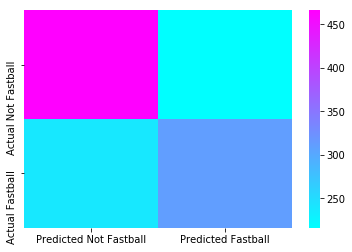

,Predicted Not Fastball,Predicted Fastball
Actual Not Fastball,466,216
Actual Fastball,239,311


In [172]:
model = search.best_estimator_
con_matrix_analysis(model, X, X_test, y, y_test)

In [173]:
get_accuracy_metrics(model, X, y, X_test, y_test)

Test R2 score: 0.6306818181818182
Accuracy 0.6306818181818182
Roc_Auc score: 0.6630285257264729


(0.6306818181818182, 0.6306818181818182, 0.6630285257264729)

In [1]:
import graphviz
from sklearn.tree import export_graphviz

feature_names = train.drop(columns=drop_cols).columns.tolist()
model.fit(X, y)
estimator = model.estimators_[5]


dot_data = export_graphviz(estimator, 
                out_file=None, #'tree.dot', 
                feature_names = feature_names,
                #class_names = ['Fastball', 'Not Fastball'],
                rounded = True, proportion = True, 
                precision = 2, filled = True)

graphviz.Source(dot_data)

ModuleNotFoundError: No module named 'graphviz'

## Gradient Boosted Classifier

In [174]:
param_grid = {
    'loss' : ['deviance'],# 'exponential'],
    'learning_rate': [0.01],
    'n_estimators': [30, 40, 60, 100],
    'subsample': [.8],
    'min_samples_split': [5, 8, 12],
    'min_samples_leaf': [6, 8, 11],
    'max_depth': [4, 6, 10],
    'max_features': [.75]
}

gbc = GradientBoostingClassifier(random_state=42)

search = GridSearchCV(
    estimator = gbc, 
    param_grid = param_grid,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    verbose=10,
    return_train_score=True
)

search.fit(X, y)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:  

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'loss': ['deviance'], 'learning_rate': [0.01], 'n_estimators': [30, 40, 60, 100], 'subsample': [0.8], 'min_samples_split': [5, 8, 12], 'min_samples_leaf': [6, 8, 11], 'max_depth': [4, 6, 10], 'max_features': [0.75]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=10)

In [175]:
search_results = pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score')
search_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_loss,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
39,5.028156,0.066541,0.019380,0.000295,0.01,deviance,6,0.75,6,5,100,0.8,"{'learning_rate': 0.01, 'loss': 'deviance', 'm...",0.606681,0.587284,0.608836,0.594391,0.593312,0.598103,0.008279,1,0.792183,0.781941,0.798922,0.792509,0.794934,0.792098,0.005621
43,5.019648,0.077164,0.020978,0.000684,0.01,deviance,6,0.75,6,8,100,0.8,"{'learning_rate': 0.01, 'loss': 'deviance', 'm...",0.606681,0.587284,0.608836,0.594391,0.593312,0.598103,0.008279,1,0.792183,0.781941,0.798922,0.792509,0.794934,0.792098,0.005621
47,5.019104,0.059404,0.019841,0.000345,0.01,deviance,6,0.75,6,12,100,0.8,"{'learning_rate': 0.01, 'loss': 'deviance', 'm...",0.606681,0.587284,0.608836,0.594391,0.593312,0.598103,0.008279,1,0.792183,0.781941,0.798922,0.792509,0.794934,0.792098,0.005621
59,4.931506,0.034595,0.019800,0.000333,0.01,deviance,6,0.75,8,12,100,0.8,"{'learning_rate': 0.01, 'loss': 'deviance', 'm...",0.614224,0.577586,0.588362,0.590076,0.598706,0.593790,0.012230,4,0.785714,0.775741,0.790027,0.789275,0.787119,0.785575,0.005150
55,4.899955,0.032873,0.019970,0.000535,0.01,deviance,6,0.75,8,8,100,0.8,"{'learning_rate': 0.01, 'loss': 'deviance', 'm...",0.614224,0.577586,0.588362,0.590076,0.598706,0.593790,0.012230,4,0.785714,0.775741,0.790027,0.789275,0.787119,0.785575,0.005150


              precision    recall  f1-score   support

Not Fastball       0.67      0.66      0.66       682
    Fastball       0.58      0.59      0.59       550

   micro avg       0.63      0.63      0.63      1232
   macro avg       0.62      0.63      0.63      1232
weighted avg       0.63      0.63      0.63      1232



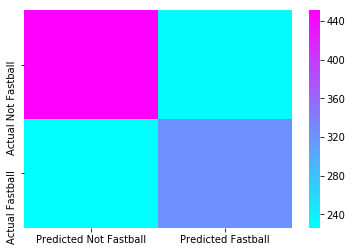

,Predicted Not Fastball,Predicted Fastball
Actual Not Fastball,451,231
Actual Fastball,226,324


In [176]:
model = search.best_estimator_
con_matrix_analysis(model, X, X_test, y, y_test)

In [177]:
get_accuracy_metrics(model, X, y, X_test, y_test)

Test R2 score: 0.6290584415584416
Accuracy 0.6290584415584416
Roc_Auc score: 0.6643401759530791


(0.6290584415584416, 0.6290584415584416, 0.6643401759530791)

## Support Vector Machine

In [ ]:
#1 hot encode instead of label encode:

In [ ]:
# sum = 0
# for col in cat_cols:
#     sum += df[col].nunique()
#     print(col + ': ' + str(df[col].nunique()))
    
# print(sum)

In [14]:
one_hot_cols = set(cat_cols) - set(['index', 'player_name', 'game_date', 'pitch_cat', 'pitcher', 'pitch_type', 'fastball_target'])

one_hot_df = pd.get_dummies(df, prefix_sep='_',columns=one_hot_cols)

train, test = train_test_split_by_date(one_hot_df, .9)

#target = 'pitch_cat'
target = 'fastball_target'

drop_cols = ['index', 'player_name', 'game_date', 'pitch_cat', 'pitcher', 'pitch_type', target]

X = train.drop(columns=drop_cols)
X_test = test.drop(columns=drop_cols)

y = train[target]
y_test = test[target]

X.shape, X_test.shape, y.shape, y_test.shape

train shape: (5205, 241)
test shape: (665, 241)


((5205, 234), (665, 234), (5205,), (665,))

In [33]:
#scale the float cols:
scale_cols = ['fastball_perc_faced', 'fastball_chase_perc', 'fastball_bip_swung_perc', 'fastball_taken_strike_perc',
              'fastball_est_woba', 'fastball_babip', 'fastball_iso_value', 'breaking_perc_faced', 'breaking_chase_perc',
              'breaking_bip_swung_perc', 'breaking_taken_strike_perc', 'breaking_est_woba', 'breaking_babip',
              'breaking_iso_value', 'offspeed_perc_faced', 'offspeed_chase_perc', 'offspeed_bip_swung_perc',
              'offspeed_taken_strike_perc', 'offspeed_est_woba', 'offspeed_babip', 'offspeed_iso_value',
              'pitchout_perc_faced', 'overall_fastball_perc', 'count_cat_fastball_perc', 'overall_breaking_perc',
              'count_cat_breaking_perc', 'overall_offspeed_perc', 'count_cat_offspeed_perc', 'L5_fastball_perc',
              'L15_fastball_perc', 'L5_breaking_perc', 'L15_breaking_perc', 'L5_offspeed_perc', 'L15_offspeed_perc',
              'L5_strike_perc', 'L15_strike_perc', 'PB_fastball', 'PB_breaking', 'PB_offspeed']

scaler = RobustScaler()
X[scale_cols] = scaler.fit_transform(X[scale_cols].values)
X_test[scale_cols] = scaler.transform(X_test[scale_cols].values)

In [34]:
X_test.head()

,on_3b,on_2b,on_1b,outs_when_up,inning,sz_top,sz_bot,at_bat_number,pitch_number,bat_score,score_diff,bases_loaded,fastball_perc_faced,fastball_chase_perc,fastball_bip_swung_perc,fastball_taken_strike_perc,fastball_est_woba,fastball_babip,fastball_iso_value,breaking_perc_faced,breaking_chase_perc,breaking_bip_swung_perc,breaking_taken_strike_perc,breaking_est_woba,breaking_babip,breaking_iso_value,offspeed_perc_faced,offspeed_chase_perc,offspeed_bip_swung_perc,offspeed_taken_strike_perc,offspeed_est_woba,offspeed_babip,offspeed_iso_value,pitchout_perc_faced,balls,strikes,overall_fastball_perc,count_cat_fastball_perc,overall_offspeed_perc,count_cat_offspeed_perc,overall_breaking_perc,count_cat_breaking_perc,pitch_count,L5_fastball_perc,L15_fastball_perc,L5_breaking_perc,L15_breaking_perc,L5_offspeed_perc,L15_offspeed_perc,L5_strike_perc,L15_strike_perc,pitcher_AB,prev_ab_run_scored,prev_ab_homerun,prev_ab_walk,prev_ab_basehit,prev_ab_strikeout,PB_fastball,PB_breaking,PB_offspeed,month,on_base,L3_chased_-1.0,L3_chased_0.0,L3_chased_1.0,L1_pitch_type_CH,L1_pitch_type_CU,L1_pitch_type_EP,L1_pitch_type_FC,L1_pitch_type_FF,L1_pitch_type_FS,L1_pitch_type_FT,L1_pitch_type_N/A,L1_pitch_type_SL,L1_description_N/A,L1_description_ball,L1_description_blocked_ball,L1_description_called_strike,L1_description_foul,L1_description_foul_bunt,L1_description_foul_tip,L1_description_hit_by_pitch,L1_description_hit_into_play,L1_description_hit_into_play_no_out,L1_description_hit_into_play_score,L1_description_swinging_strike,L1_description_swinging_strike_blocked,L3_pitch_zone_-1.0,L3_pitch_zone_1.0,L3_pitch_zone_2.0,L3_pitch_zone_3.0,L3_pitch_zone_4.0,L3_pitch_zone_5.0,L3_pitch_zone_6.0,L3_pitch_zone_7.0,L3_pitch_zone_8.0,L3_pitch_zone_9.0,L3_pitch_zone_11.0,L3_pitch_zone_12.0,L3_pitch_zone_13.0,L3_pitch_zone_14.0,L1_pitch_result_B,L1_pitch_result_N/A,L1_pitch_result_S,L1_pitch_result_X,if_fielding_alignment_Infield shift,if_fielding_alignment_Standard,if_fielding_alignment_Strategic,stand_L,stand_R,L1_batter_swung_-1.0,L1_batter_swung_0.0,L1_batter_swung_1.0,L2_pitch_result_B,L2_pitch_result_N/A,L2_pitch_result_S,L2_pitch_result_X,count_cat_ahead,count_cat_behind,count_cat_neutral,L2_pitch_zone_-1.0,L2_pitch_zone_1.0,L2_pitch_zone_2.0,L2_pitch_zone_3.0,L2_pitch_zone_4.0,L2_pitch_zone_5.0,L2_pitch_zone_6.0,L2_pitch_zone_7.0,L2_pitch_zone_8.0,L2_pitch_zone_9.0,L2_pitch_zone_11.0,L2_pitch_zone_12.0,L2_pitch_zone_13.0,L2_pitch_zone_14.0,_count_00,_count_01,_count_02,_count_10,_count_11,_count_12,_count_20,_count_21,_count_22,_count_30,_count_31,_count_32,L3_description_N/A,L3_description_ball,L3_description_blocked_ball,L3_description_called_strike,L3_description_foul,L3_description_foul_bunt,L3_description_foul_tip,L3_description_hit_by_pitch,L3_description_hit_into_play,L3_description_hit_into_play_no_out,L3_description_hit_into_play_score,L3_description_swinging_strike,L3_description_swinging_strike_blocked,catcher_id_425772.0,catcher_id_455139.0,catcher_id_488671.0,catcher_id_543376.0,catcher_id_571974.0,catcher_id_608348.0,L1_chased_-1.0,L1_chased_0.0,L1_chased_1.0,inning_topbot_Bot,inning_topbot_Top,L1_pitch_zone_-1.0,L1_pitch_zone_1.0,L1_pitch_zone_2.0,L1_pitch_zone_3.0,L1_pitch_zone_4.0,L1_pitch_zone_5.0,L1_pitch_zone_6.0,L1_pitch_zone_7.0,L1_pitch_zone_8.0,L1_pitch_zone_9.0,L1_pitch_zone_11.0,L1_pitch_zone_12.0,L1_pitch_zone_13.0,L1_pitch_zone_14.0,L2_description_N/A,L2_description_ball,L2_description_blocked_ball,L2_description_called_strike,L2_description_foul,L2_description_foul_bunt,L2_description_foul_tip,L2_description_hit_by_pitch,L2_description_hit_into_play,L2_description_hit_into_play_no_out,L2_description_hit_into_play_score,L2_description_swinging_strike,L2_description_swinging_strike_blocked,of_fielding_alignment_4th outfielder,of_fielding_alignment_Standard,of_fielding_alignment_Strategic,L3_pitch_type_CH,L3_pitch_type_CU,L3_pitch_type_EP,L3_pitch_type_FC,L3_pitch_type_FF,L3_pitch_type_FS,L3_pitch_type_FT,L3_pitch_type_N/A,L3_pit

In [188]:
%%time
from sklearn.svm import SVC

param_grid = {
    'degree': [3,4],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'tol': [0.0005, 0.0001, 0.00005],#, 0.000001],
    'C': [0.2, 0.5, 1.0],#, 4.0],#, 5.0],
    'shrinking': [True, False],
    'class_weight': [None],
    'max_iter': [400, 600],#, 1500, 2000, 2500],
    'decision_function_shape': ['ovo', 'ovr']
}

#'gamma': ['auto', 'scale']

svm = SVC(random_state=42, verbose=50)

search = GridSearchCV(
    estimator = svm, 
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=-1,
    cv=3,
    verbose=10,
    return_train_score=True
)

search.fit(X, y)

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:  

[LibSVM]CPU times: user 19.9 s, sys: 679 ms, total: 20.5 s
Wall time: 1min 58s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=400).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [189]:
search_results = pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score')
search_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_decision_function_shape,param_degree,param_kernel,param_max_iter,param_shrinking,param_tol,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
281,0.450983,0.004398,0.203381,0.000325,0.5,None,ovo,4,sigmoid,400,False,5e-05,"{'C': 0.5, 'class_weight': None, 'decision_fun...",0.557854,0.528461,0.51521,0.533851,0.017822,1,0.527014,0.538486,0.537342,0.534281,0.00516
328,0.457254,0.013787,0.208542,0.006007,0.5,None,ovr,3,sigmoid,400,False,0.0001,"{'C': 0.5, 'class_weight': None, 'decision_fun...",0.557854,0.528461,0.51521,0.533851,0.017822,1,0.527014,0.538486,0.537342,0.534281,0.00516
327,0.472173,0.023875,0.204708,0.000854,0.5,None,ovr,3,sigmoid,400,False,0.0005,"{'C': 0.5, 'class_weight': None, 'decision_fun...",0.557854,0.528461,0.51521,0.533851,0.017822,1,0.527014,0.538486,0.537342,0.534281,0.00516
326,0.479549,0.035820,0.202950,0.001236,0.5,None,ovr,3,sigmoid,400,True,5e-05,"{'C': 0.5, 'class_weight': None, 'decision_fun...",0.557854,0.528461,0.51521,0.533851,0.017822,1,0.527014,0.538486,0.537342,0.534281,0.00516
325,0.531174,0.054393,0.203649,0.000623,0.5,None,ovr,3,sigmoid,400,True,0.0001,"{'C': 0.5, 'class_weight': None, 'decision_fun...",0.557854,0.528461,0.51521,0.533851,0.017822,1,0.527014,0.538486,0.537342,0.534281,0.00516


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[LibSVM]

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=400).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


              precision    recall  f1-score   support

Not Fastball       0.59      0.66      0.62       682
    Fastball       0.51      0.44      0.47       550

   micro avg       0.56      0.56      0.56      1232
   macro avg       0.55      0.55      0.55      1232
weighted avg       0.55      0.56      0.55      1232



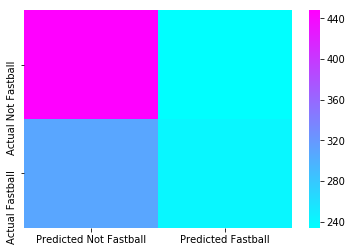

,Predicted Not Fastball,Predicted Fastball
Actual Not Fastball,448,234
Actual Fastball,309,241


In [190]:
model = search.best_estimator_
con_matrix_analysis(model, X, X_test, y, y_test)

## Linear SVC

In [191]:
%%time
from sklearn.svm import LinearSVC

param_grid = {
    'penalty': ['l1'],#, 'l1'],
    'loss': ['squared_hinge'],#'hinge'
    'dual': [False],
    'tol': [0.0005, 0.0001, 0.00005, 0.000001],
    'C': [3.0, 4.0, 5.0],
    #'multi_class': ['ovr'],
    'class_weight': [None],
    'max_iter': [400, 500, 600],#, 1500, 2000, 2500],
    'fit_intercept': [False]
}

svm = LinearSVC(random_state=42, verbose=50)

search = GridSearchCV(
    estimator = svm, 
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=-1,
    cv=6,
    verbose=10,
    return_train_score=True
)

search.fit(X, y)

Fitting 6 folds for each of 36 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 207 out of 216 | elapsed:   12.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:   13.1s finished


[LibLinear]CPU times: user 2.98 s, sys: 64.2 ms, total: 3.04 s
Wall time: 13.5 s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [192]:
search_results = pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score')
search_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_dual,param_fit_intercept,param_loss,param_max_iter,param_penalty,param_tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,mean_train_score,std_train_score
0,0.692093,0.012115,0.011471,0.000402,3,None,False,False,squared_hinge,400,l1,0.0005,"{'C': 3.0, 'class_weight': None, 'dual': False...",0.595607,0.583441,0.592497,0.588616,0.608021,0.621762,0.598318,0.012908,1,0.628364,0.628978,0.629495,0.630013,0.627684,0.626487,0.628504,0.001172
1,0.713038,0.021712,0.011512,0.000313,3,None,False,False,squared_hinge,400,l1,0.0001,"{'C': 3.0, 'class_weight': None, 'dual': False...",0.595607,0.583441,0.592497,0.588616,0.608021,0.621762,0.598318,0.012908,1,0.628364,0.628978,0.629495,0.630013,0.627684,0.626487,0.628504,0.001172
2,0.706581,0.020682,0.011593,0.000339,3,None,False,False,squared_hinge,400,l1,5e-05,"{'C': 3.0, 'class_weight': None, 'dual': False...",0.595607,0.583441,0.592497,0.588616,0.608021,0.621762,0.598318,0.012908,1,0.628364,0.628978,0.629495,0.630013,0.627684,0.626487,0.628504,0.001172
3,0.713427,0.012621,0.011571,0.000228,3,None,False,False,squared_hinge,400,l1,1e-06,"{'C': 3.0, 'class_weight': None, 'dual': False...",0.595607,0.583441,0.592497,0.588616,0.608021,0.621762,0.598318,0.012908,1,0.628364,0.628978,0.629495,0.630013,0.627684,0.626487,0.628504,0.001172
23,1.037739,0.019527,0.011424,0.000211,4,None,False,False,squared_hinge,600,l1,1e-06,"{'C': 4.0, 'class_weight': None, 'dual': False...",0.587855,0.584735,0.592497,0.589909,0.613195,0.620466,0.598103,0.013599,5,0.628882,0.627684,0.629237,0.629754,0.626649,0.627781,0.628331,0.001057


[LibLinear]              precision    recall  f1-score   support

Not Fastball       0.70      0.56      0.63       682
    Fastball       0.57      0.71      0.63       550

   micro avg       0.63      0.63      0.63      1232
   macro avg       0.64      0.63      0.63      1232
weighted avg       0.64      0.63      0.63      1232



/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


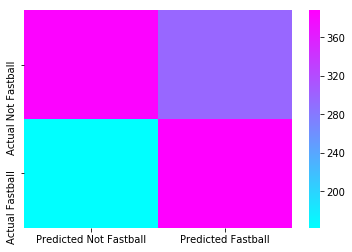

,Predicted Not Fastball,Predicted Fastball
Actual Not Fastball,385,297
Actual Fastball,162,388


In [193]:
model = search.best_estimator_
con_matrix_analysis(model, X, X_test, y, y_test)

In [194]:
#get_accuracy_metrics(model, X, y, X_test, y_test)

## SGDClassifier

In [178]:
%%time
from sklearn.linear_model import SGDClassifier

param_grid = {
    'penalty': ['l2', 'elasticnet'],
    'alpha': [0.010, 0.011, 0.012],
    'loss': ['hinge', 'perceptron'],#'hinge'
    'tol': [0.00011, 0.00009],#, 0.00005],
    #'multi_class': ['ovr'],
    'class_weight': [None],
    'max_iter': [40000, 100000, 200000],#, 1500, 2000, 2500],
    'fit_intercept': [True],#, False],
    'warm_start': [True],#, False],
    'learning_rate': ['optimal']
}

sgd = SGDClassifier(random_state=42, verbose=50)

search = GridSearchCV(
    estimator = sgd, 
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=-1,
    cv=6,
    verbose=10,
    return_train_score=True
)

search.fit(X, y)

Fitting 6 folds for each of 72 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:  

-- Epoch 1
Norm: 37.11, NNZs: 50, Bias: 4.897883, T: 4638, Avg. loss: 94.620863
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 34.18, NNZs: 35, Bias: 4.714757, T: 9276, Avg. loss: 6.539472
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 30.57, NNZs: 37, Bias: 4.494084, T: 13914, Avg. loss: 4.116299
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 28.97, NNZs: 39, Bias: 4.300688, T: 18552, Avg. loss: 2.189076
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 27.49, NNZs: 35, Bias: 4.110140, T: 23190, Avg. loss: 1.765966
Total training time: 0.02 seconds.
-- Epoch 6
Norm: 26.10, NNZs: 35, Bias: 4.003156, T: 27828, Avg. loss: 1.595863
Total training time: 0.02 seconds.
-- Epoch 7
Norm: 24.08, NNZs: 41, Bias: 3.969518, T: 32466, Avg. loss: 2.303768
Total training time: 0.02 seconds.
-- Epoch 8
Norm: 23.08, NNZs: 43, Bias: 3.896210, T: 37104, Avg. loss: 1.461682
Total training time: 0.03 seconds.
-- Epoch 9
Norm: 21.73, NNZs: 45, Bias: 3.846194, T: 41742, Avg. loss: 1.830262
T

[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:    8.0s finished


In [179]:
search_results = pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score')
search_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_class_weight,param_fit_intercept,param_learning_rate,param_loss,param_max_iter,param_penalty,param_tol,param_warm_start,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,mean_train_score,std_train_score
2,0.162500,0.081031,0.066828,0.052205,0.01,None,True,optimal,hinge,40000,elasticnet,0.00011,True,"{'alpha': 0.01, 'class_weight': None, 'fit_int...",0.577519,0.575679,0.574386,0.576973,0.605433,0.497409,0.567917,0.033289,1,0.601708,0.621475,0.582147,0.616818,0.615783,0.500517,0.589741,0.041992
3,0.178533,0.092966,0.010325,0.001123,0.01,None,True,optimal,hinge,40000,elasticnet,9e-05,True,"{'alpha': 0.01, 'class_weight': None, 'fit_int...",0.577519,0.575679,0.574386,0.576973,0.605433,0.497409,0.567917,0.033289,1,0.601708,0.621475,0.582147,0.616818,0.615783,0.500517,0.589741,0.041992
6,0.198826,0.103536,0.010801,0.000354,0.01,None,True,optimal,hinge,100000,elasticnet,0.00011,True,"{'alpha': 0.01, 'class_weight': None, 'fit_int...",0.577519,0.575679,0.574386,0.576973,0.605433,0.497409,0.567917,0.033289,1,0.601708,0.621475,0.582147,0.616818,0.615783,0.500517,0.589741,0.041992
7,0.190575,0.100639,0.011000,0.000497,0.01,None,True,optimal,hinge,100000,elasticnet,9e-05,True,"{'alpha': 0.01, 'class_weight': None, 'fit_int...",0.577519,0.575679,0.574386,0.576973,0.605433,0.497409,0.567917,0.033289,1,0.601708,0.621475,0.582147,0.616818,0.615783,0.500517,0.589741,0.041992
10,0.193297,0.099605,0.010857,0.000401,0.01,None,True,optimal,hinge,200000,elasticnet,0.00011,True,"{'alpha': 0.01, 'class_weight': None, 'fit_int...",0.577519,0.575679,0.574386,0.576973,0.605433,0.497409,0.567917,0.033289,1,0.601708,0.621475,0.582147,0.616818,0.615783,0.500517,0.589741,0.041992


-- Epoch 1
Norm: 37.44, NNZs: 49, Bias: 8.881711, T: 4638, Avg. loss: 90.364613
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 33.42, NNZs: 42, Bias: 8.579683, T: 9276, Avg. loss: 7.040212
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 31.09, NNZs: 35, Bias: 8.222585, T: 13914, Avg. loss: 3.370589
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 29.26, NNZs: 40, Bias: 7.907075, T: 18552, Avg. loss: 2.104796
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 26.88, NNZs: 40, Bias: 7.736202, T: 23190, Avg. loss: 2.355903
Total training time: 0.02 seconds.
-- Epoch 6
Norm: 24.46, NNZs: 38, Bias: 7.660562, T: 27828, Avg. loss: 2.787275
Total training time: 0.02 seconds.
-- Epoch 7
Norm: 22.40, NNZs: 44, Bias: 7.593269, T: 32466, Avg. loss: 2.634281
Total training time: 0.02 seconds.
-- Epoch 8
Norm: 21.30, NNZs: 46, Bias: 7.502877, T: 37104, Avg. loss: 1.819357
Total training time: 0.03 seconds.
-- Epoch 9
Norm: 19.95, NNZs: 47, Bias: 7.447424, T: 41742, Avg. loss: 2.090797
T

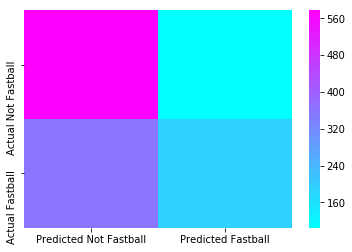

,Predicted Not Fastball,Predicted Fastball
Actual Not Fastball,577,105
Actual Fastball,360,190


In [180]:
model = search.best_estimator_
con_matrix_analysis(model, X, X_test, y, y_test)

## LDA

In [181]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

param_grid = {
    'solver': ['lsqr'],#, 'eigen'],
    'shrinkage': [None, 'auto', 0.1, 0.5],
    'tol': [0.00001, 0.000001, 0.0000005, 0.00000001],
    'n_components':[None, 25, 100, 200, 300],
    #'store_covariance': [True, False]
}

lda = LinearDiscriminantAnalysis()

search = GridSearchCV(
    estimator = lda, 
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=-1,
    cv=6,
    verbose=10,
    return_train_score=True
)

search.fit(X, y)

Fitting 6 folds for each of 80 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1393s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 346 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 388 ta

GridSearchCV(cv=6, error_score='raise-deprecating',
       estimator=LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'solver': ['lsqr'], 'shrinkage': [None, 'auto', 0.1, 0.5], 'tol': [1e-05, 1e-06, 5e-07, 1e-08], 'n_components': [None, 25, 100, 200, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=10)

In [182]:
search_results = pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score')
search_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_components,param_shrinkage,param_solver,param_tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,mean_train_score,std_train_score
39,0.138449,0.003625,0.010934,0.000166,100,auto,lsqr,1e-08,"{'n_components': 100, 'shrinkage': 'auto', 'so...",0.593023,0.592497,0.597671,0.587322,0.610608,0.629534,0.601768,0.014353,1,0.625259,0.629237,0.628719,0.630272,0.626391,0.626229,0.627684,0.001819
36,0.140761,0.003650,0.011809,0.000585,100,auto,lsqr,1e-05,"{'n_components': 100, 'shrinkage': 'auto', 'so...",0.593023,0.592497,0.597671,0.587322,0.610608,0.629534,0.601768,0.014353,1,0.625259,0.629237,0.628719,0.630272,0.626391,0.626229,0.627684,0.001819
37,0.141924,0.005568,0.011331,0.000302,100,auto,lsqr,1e-06,"{'n_components': 100, 'shrinkage': 'auto', 'so...",0.593023,0.592497,0.597671,0.587322,0.610608,0.629534,0.601768,0.014353,1,0.625259,0.629237,0.628719,0.630272,0.626391,0.626229,0.627684,0.001819
38,0.140407,0.002160,0.011318,0.000170,100,auto,lsqr,5e-07,"{'n_components': 100, 'shrinkage': 'auto', 'so...",0.593023,0.592497,0.597671,0.587322,0.610608,0.629534,0.601768,0.014353,1,0.625259,0.629237,0.628719,0.630272,0.626391,0.626229,0.627684,0.001819
23,0.138576,0.006233,0.011770,0.000755,25,auto,lsqr,1e-08,"{'n_components': 25, 'shrinkage': 'auto', 'sol...",0.593023,0.592497,0.597671,0.587322,0.610608,0.629534,0.601768,0.014353,1,0.625259,0.629237,0.628719,0.630272,0.626391,0.626229,0.627684,0.001819
22,0.138472,0.005381,0.011164,0.000396,25,auto,lsqr,5e-07,"{'n_components': 25, 'shrinkage': 'auto', 'sol...",0.593023,0.592497,0.597671,0.587322,0.610608,0.629534,0.601768,0.014353,1,0.625259,0.629237,0.628719,0.630272,0.626391,0.626229,0.627684,0.001819
21,0.141893,0.004076,0.011552,0.000502,25,auto,lsqr,1e-06,"{'n_components': 25, 'shrinkage': 'auto', 'sol...",0.593023,0.592497,0.597671,0.587322,0.610608,0.629534,0.601768,0.014353,1,0.625259,0.629237,0.628719,0.630272,0.626391,0.626229,0.627684,0.001819
20,0.141654,0.002883,0.012520,0.001846,25,auto,lsqr,1e-05,"{'n_components': 25, 'shrinkage': 'auto', 'sol...",0.593023,0.592497,0.597671,0.587322,0.610608,0.629534,0.601768,0.014353,1,0.625259,0.629237,0.628719,0.630272,0.626391,0.626229,0.627684,0.001819
52,0.139411,0.000976,0.011345,0.000285,200,auto,lsqr,1e-05,"{'n_components': 200, 'shrinkage': 'auto', 'so...",0.593023,0.592497,0.597671,0.587322,0.610608,0.629534,0.601768,0.014353,1,0.625259,0.629237,0.628719,0.630272,0.626391,0.626229,0.627684,0.001819
54,0.138261,0.003717,0.011093,0.000433,200,auto,lsqr,5e-07,"{'n_components': 200, 'shrinkage': 'auto', 'so...",0.593023,0.592497,0.597671,0.587322,0.610608,0.629534,0.601768,0.014353,1,0.625259,0.629237,0.628719,0.630272,0.626391,0.626229,0.627684,0.001819


              precision    recall  f1-score   support

Not Fastball       0.70      0.60      0.65       682
    Fastball       0.58      0.68      0.62       550

   micro avg       0.64      0.64      0.64      1232
   macro avg       0.64      0.64      0.64      1232
weighted avg       0.64      0.64      0.64      1232



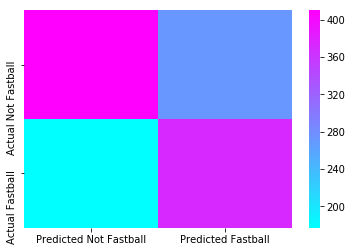

,Predicted Not Fastball,Predicted Fastball
Actual Not Fastball,410,272
Actual Fastball,177,373


In [183]:
model = search.best_estimator_
con_matrix_analysis(model, X, X_test, y, y_test)

## Feature Importances

In [184]:
model.fit(X, y)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage='auto',
              solver='lsqr', store_covariance=False, tol=1e-05)

In [185]:
importances = pd.Series(model.feature_importances_, X.columns)
importances.head(20).sort_values().plot.barh()
plt.show()

AttributeError: 'LinearDiscriminantAnalysis' object has no attribute 'feature_importances_'

In [186]:
importances = pd.Series(model.feature_importances_, X.columns)
importances.tail(20).sort_values().plot.barh()
plt.show()

AttributeError: 'LinearDiscriminantAnalysis' object has no attribute 'feature_importances_'

In [187]:
permuter = PermutationImportance(model, scoring='accuracy', cv='prefit', 
                                 n_iter=5, random_state=42)

permuter.fit(X, y)

feature_names = train.drop(columns=drop_cols).columns.tolist()

eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.0812 ± 0.0042,strikes
0.0080 ± 0.0062,on_1b
0.0073 ± 0.0039,count_cat_breaking_perc
0.0072 ± 0.0055,offspeed_iso_value
0.0072 ± 0.0064,at_bat_number
0.0063 ± 0.0046,balls
0.0054 ± 0.0035,L5_strike_perc
0.0053 ± 0.0033,breaking_babip
0.0052 ± 0.0052,breaking_iso_value
0.0048 ± 0.0033,on_base


In [155]:
#Make a dataframe of the elie_weights importances:
eli_importances_df = eli5.explain_weights_df(permuter, feature_names=feature_names)

#inspect the 20 features w/ most importance
eli_importances_df.sort_values(by='weight', ascending=False).head(20)

,feature,weight,std
0,at_bat_number,0.054627,0.001044
1,pitch_number,0.021518,0.002828
2,pitch_count,0.011976,0.006480
3,on_1b,0.005636,0.002198
4,strikes,0.004867,0.001832
5,breaking_babip,0.004227,0.001255
6,month,0.004227,0.000941
7,on_base,0.004227,0.001412
8,offspeed_iso_value,0.003778,0.000864
9,outs_when_up,0.003714,0.001177


In [156]:
#inspect the 20 features w/ least importance
eli_importances_df.sort_values(by='weight', ascending=False).tail(20)

,feature,weight,std
214,L2_pitch_type_EP,-0.000384,0.000157
215,if_fielding_alignment_Infield shift,-0.000448,0.000479
216,L3_pitch_zone_8.0,-0.000512,0.000091
217,L2_chased_0.0,-0.000512,0.000181
218,count_cat_neutral,-0.000512,0.000240
221,L1_pitch_zone_8.0,-0.000576,0.000157
219,L1_description_swinging_strike,-0.000576,0.000314
220,L2_pitch_type_CH,-0.000576,0.000415
222,catcher_id_488671.0,-0.000640,0.000240
223,of_fielding_alignment_Strategic,-0.000768,0.000272
